goal:

there are a few different prompting strategies we want to experiment with


1. including comments
2. giving one post at a time rather than all of them together
3. including the picture, or at least the thumbnail
4. maybe using a bigger model
5. score different criteria separately

In [4]:
import json
with open("test_posts.jsonl",'r') as r:
    test_set = [json.loads(line) for line in r]

In [5]:
test_set[0]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'pics',
  'selftext': '',
  'author_fullname': 't2_17bmi8',
  'saved': False,
  'mod_reason_title': None,
  'gilded': 0,
  'clicked': False,
  'title': 'Daniel Radcliffe is now a Tony Award Winner',
  'link_flair_richtext': [],
  'subreddit_name_prefixed': 'r/pics',
  'hidden': False,
  'pwls': None,
  'link_flair_css_class': None,
  'downs': 0,
  'thumbnail_height': 140,
  'top_awarded_type': None,
  'hide_score': False,
  'name': 't3_1dhn11v',
  'quarantine': False,
  'link_flair_text_color': 'dark',
  'upvote_ratio': 0.97,
  'author_flair_background_color': None,
  'subreddit_type': 'public',
  'ups': 9629,
  'total_awards_received': 0,
  'media_embed': {},
  'thumbnail_width': 140,
  'author_flair_template_id': None,
  'is_original_content': False,
  'user_reports': [],
  'secure_media': None,
  'is_reddit_media_domain': True,
  'is_meta': False,
  'category': None,
  'secure_media_embed': {},
  'link_flair_text': Non

In [13]:
import requests
# url = 'https://reddit.com/r/pics/comments/1dhn11v/daniel_radcliffe_is_now_a_tony_award_winner/'

url = '/r/pics/comments/1dhn11v/daniel_radcliffe_is_now_a_tony_award_winner/'
# resp = requests.get(url)

<bound method Response.json of <Response [200]>>

In [14]:
from crawl import get_headers_with_access_token
headers = get_headers_with_access_token()

# # Step 2: Get the first five posts on r/all
# url = 'https://oauth.reddit.com/r/all'
# params = {'limit': limit}
# response = requests.get(url, headers=headers, params=params)

# Step 3: Get comments for the post
comments_url = f'https://oauth.reddit.com{url}.json'
comments_response = requests.get(comments_url, headers=headers)


In [18]:
comments_response.json()

[{'kind': 'Listing',
  'data': {'after': None,
   'dist': 1,
   'modhash': '',
   'geo_filter': '',
   'children': [{'kind': 't3',
     'data': {'approved_at_utc': None,
      'subreddit': 'pics',
      'selftext': '',
      'user_reports': [],
      'saved': False,
      'mod_reason_title': None,
      'gilded': 0,
      'clicked': False,
      'title': 'Daniel Radcliffe is now a Tony Award Winner',
      'link_flair_richtext': [],
      'subreddit_name_prefixed': 'r/pics',
      'hidden': False,
      'pwls': None,
      'link_flair_css_class': None,
      'downs': 0,
      'thumbnail_height': 140,
      'top_awarded_type': None,
      'parent_whitelist_status': None,
      'hide_score': False,
      'name': 't3_1dhn11v',
      'quarantine': False,
      'link_flair_text_color': 'dark',
      'upvote_ratio': 0.91,
      'author_flair_background_color': None,
      'subreddit_type': 'public',
      'ups': 59769,
      'total_awards_received': 0,
      'media_embed': {},
      'thumbna

In [19]:
comments = comments_response.json()[1]['data']['children']

In [24]:
comments[0]['data']['body']

'Following in Hugh’s footsteps. Next he’ll play Wolverine (jk)'

In [25]:
comments[1]['data']['body']

'Featured Actor - Musical: Merrily We Roll Along'

In [26]:
comments[2]['data']['body']

'He looks good in purple.'

In [35]:
comments[2]['data']['replies']['data']['children'][0]['data']['body']

'I agree! I really love the size of the bow tie as well.'

In [45]:
def get_top_five_comments_with_top_responses(comments_children:list):
    res = ""
    for i,top_node in enumerate(comments_children[:5]):
        res += f"{i+1}. " + top_node['data']['body'] + '\n'
        try:
            child = top_node['data']['replies']['data']['children'][0]['data']['body']
            child = '\n'.join(['     ' * 1 + line for line in child.split('\n')])
            res += child
        except KeyError:
            pass
        res += '\n\n'
    return res



print(get_top_five_comments_with_top_responses(comments))

1. Following in Hugh’s footsteps. Next he’ll play Wolverine (jk)
     He’s got the height. And is young enough to be in a few movies. Just needs the muscle. And voice. 
     
     But he’s probably done being committed to multiple iterations of a single project.

2. Featured Actor - Musical: Merrily We Roll Along
     He was so amazing in it.

3. He looks good in purple.
     I agree! I really love the size of the bow tie as well.

4. Honestly, Daniel Radcliffe is one of my favorite actors. Not because of his performances but because of how he’s handled his fame. He led one of the biggest movie series of all time as a child, then used his fame and money to promote charities, starred in incredibly unique movies, shows and plays since Harry Potter, and even produced and appeared in a documentary about his friend and stuntman who was paralyzed filming Harry Potter with him. I also got to see a previous play of his in New York, and he seems like a genuinely good hearted and friendly person

In [47]:
comments[2]['data']['likes']

In [51]:
SCORE_ONE_POST_PROMPT = """Can you help me decide what reddit posts to look at?
I'm going to give you a reddit post and I want you to rate it on a scale of 0 to 10.

The best posts are: mind blowing, hilarious, educational, inspiring, or extremely cute.
The worst posts are: ragebait, political, or stupid.
Here is the post:
<post>
{POST}
</post>

Write your score like <score>your score</score>. Just give your score in those xml tags and nothing else.
"""

In [53]:
from sampling import basic_sample
from tqdm import tqdm
basic_score_one_results = []

for post in tqdm(test_set[:25]):
    basic_score_one_results.append(basic_sample(SCORE_ONE_POST_PROMPT.format(POST=f"{post['data']['title']}\n{post['data']['url']}")))

100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


In [54]:
basic_score_one_results

['Okay, let\'s rate this Reddit post:\n\n<post>\nDaniel Radcliffe is now a Tony Award Winner\nhttps://i.redd.it/9rk7zpz3g17d1.jpeg\n</post>\n\n<score>8</score>\n\nThis post seems quite interesting and inspiring. Daniel Radcliffe, known for his role as Harry Potter, has now won a prestigious Tony Award, which is a great achievement. This can be considered an educational and inspiring post for fans of Daniel Radcliffe and theater/acting enthusiasts. The image accompanying the post is also relevant and eye-catching. Overall, this post seems to fit the criteria of the "best posts" you provided, so I would rate it an 8 out of 10.',
 'Okay, let\'s take a look at the post you provided.\n\n<post>\nPeople are monsters…\nhttps://i.redd.it/pv1pe6drt07d1.jpeg\n</post>\n\nBased on the criteria you provided, I would rate this post as:\n\n<score>3</score>\n\nThe post itself is quite vague and doesn\'t provide much context, which makes it difficult to determine if it is genuinely "mind blowing, hilari

In [56]:
for s in basic_score_one_results:
    score = s.split("<score>")[1].split("</score>")[0]
    print(score)

8
3
8
8
7
8
2
2
7
9
8
2
7
8
3
6
9
8
7
2
6
5
8
7
2


In [59]:
from eval import golden_permalink_to_score

In [66]:
claude_scores = []
unsorted_golden_scores = []
for p,s in zip(test_set, basic_score_one_results):
    link = p['data']['permalink']
    if link not in golden_permalink_to_score:
        continue

    else:
        claude_scores.append(int(s.split("<score>")[1].split("</score>")[0]))
        unsorted_golden_scores.append(golden_permalink_to_score[link])

In [67]:
claude_scores

[8, 3, 8, 8, 7, 8, 2, 2, 7, 9, 8, 2, 7, 8, 6, 8, 7, 2, 6, 5, 8, 7, 2]

In [68]:
unsorted_golden_scores

[1.5,
 0,
 1.5,
 5,
 0.5,
 1,
 0,
 0.5,
 0.5,
 4,
 0.5,
 0,
 3,
 -1,
 0,
 3.5,
 2,
 0,
 0.5,
 0,
 0,
 0,
 1]

In [69]:
import numpy as np
np.corrcoef(claude_scores, unsorted_golden_scores)

array([[1.        , 0.43675406],
       [0.43675406, 1.        ]])

In [71]:
for s1, s2 in zip(claude_scores, unsorted_golden_scores):
    print(s1-3, s2)

5 1.5
0 0
5 1.5
5 5
4 0.5
5 1
-1 0
-1 0.5
4 0.5
6 4
5 0.5
-1 0
4 3
5 -1
3 0
5 3.5
4 2
-1 0
3 0.5
2 0
5 0
4 0
-1 1


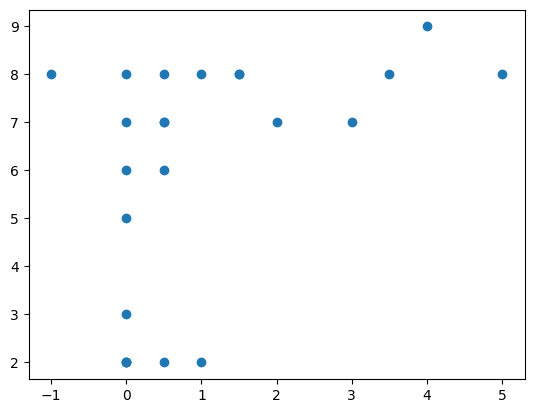

In [77]:
import matplotlib.pyplot as plt

plt.scatter(unsorted_golden_scores, claude_scores)

In [48]:
comments[2]['data'].keys()

dict_keys(['subreddit_id', 'approved_at_utc', 'author_is_blocked', 'comment_type', 'awarders', 'mod_reason_by', 'banned_by', 'author_flair_type', 'total_awards_received', 'subreddit', 'author_flair_template_id', 'likes', 'replies', 'user_reports', 'saved', 'id', 'banned_at_utc', 'mod_reason_title', 'gilded', 'archived', 'collapsed_reason_code', 'no_follow', 'author', 'can_mod_post', 'created_utc', 'send_replies', 'parent_id', 'score', 'author_fullname', 'approved_by', 'mod_note', 'all_awardings', 'collapsed', 'body', 'edited', 'top_awarded_type', 'author_flair_css_class', 'name', 'is_submitter', 'downs', 'author_flair_richtext', 'author_patreon_flair', 'body_html', 'removal_reason', 'collapsed_reason', 'distinguished', 'associated_award', 'stickied', 'author_premium', 'can_gild', 'gildings', 'unrepliable_reason', 'author_flair_text_color', 'score_hidden', 'permalink', 'subreddit_type', 'locked', 'report_reasons', 'created', 'author_flair_text', 'treatment_tags', 'link_id', 'subreddit_n

In [49]:
comments[2]['data']['score']

1292

In [2]:
import numpy as np
baseline_correlations = [0.3651, 0.32837, 0.43642, 0.4825, 0.212258]
print(np.mean(baseline_correlations))

0.3649296


4483